# Notebook \#2 - Implementation of Fourier Neural Operator

In this beginning notebook, I am going to construct a framework for learning neural operators using the Fourier Neural Operator (FNO) architecture and solve a Diffusion Problem (to be explained later). The structure of this notebook goes as follows:
- Implement a class for the FNO architecture
- Implement a function for training the FNO with given differential equations and initial/boundary conditions
- Generate a training dataset for the input control functions and the corresponding analytical solutions of the differential equation
- Define loss functions associated with physics loss, initial, and boundary conditions
- Train the FNO
- Solve the Feldbaum Problem

Let's start by implementing the Fourier Neural Operator architecture.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.fft import fft, ifft
import numpy as np
from datetime import datetime
from data import MultiFunctionDatasetODE, custom_collate_ODE_fn 

## Key Components of the FNO Architecture

### 1. Input Lifting with an MLP

- **Purpose:**  
  The first step is to "lift" the input data—typically low-dimensional features (e.g., time `t` and a function `u`)—into a higher-dimensional feature space. This is done using a Multi-Layer Perceptron (MLP).

- **Implementation:**  
  An MLP is built using a list of layer sizes (e.g., `[2, n_hid, n_hid]`) and corresponding activation functions (e.g., `['tanh', 'tanh']`). This network transforms the concatenated input `(t, u)` into a lifted representation suitable for spectral processing.

---

### 2. Spectral Convolution with Fourier Layers

- **Fourier Transform:**  
  The FNO converts the lifted input into the frequency domain using the Fast Fourier Transform (FFT). For example, in the code:

```python
  x_ft = fft(x, dim=-1)
```
#### Learnable Spectral Filtering:
In the frequency domain, a subset of the Fourier modes (specifically the lower modes, which capture the most significant features) is filtered using learnable weights. This is achieved via an efficient tensor contraction with torch.einsum:
out_ft[:, :, :self.modes] = torch.einsum("bcm,cio->bio", x_ft[:, :, :self.modes], self.weights)
Here:
```python
x_ft[:, :, :self.modes] represents the selected Fourier modes.
```
`self.weights` are learnable parameters with shape `(in_channels, out_channels, modes)`.
#### Inverse Fourier Transform:
After applying the spectral filter, the data is transformed back to the spatial domain using the inverse FFT:
```python
x_out = ifft(out_ft, dim=-1)
return x_out.real
```
Only the real part of the inverse transform is used.
#### Stacking Layers:
Multiple Fourier layers can be stacked to enhance the model’s capacity. An optional nonlinearity (such as tanh) can be applied after each Fourier layer.

### 3. Output Projection with an MLP
***Purpose:***
After spectral convolution, the data is still in a high-dimensional space. An output MLP projects this representation back to the desired output dimension (typically a scalar per input point).
***Implementation:***
Similar to the input MLP, the output MLP is built using a list of layer sizes (e.g., `[n_hid, n_hid, 1]`) and corresponding activation functions (e.g., `['tanh', None]`).


In [5]:

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bim, iom -> bom", input, weights)

    def forward(self, x):
        B, C, N = x.shape
        x_ft = fft(x, dim=-1)
        out_ft = torch.zeros(B, self.out_channels, N, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)
        x = ifft(out_ft, dim=-1).real
        return x


# -------------------------
# Fourier Layer with Dropout and Skip Connections
# -------------------------

class FourierLayerWithDropoutAndSkip(nn.Module):
    def __init__(self, width, modes, dropout_rate=0.1):
        super(FourierLayerWithDropoutAndSkip, self).__init__()
        self.fourier_conv = SpectralConv1d(width, width, modes)
        self.local_conv = nn.Conv1d(width, width, kernel_size=1)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(width)  # Normalize across the 'width' dimension

    def forward(self, x):
        residual = x
        x = self.fourier_conv(x)
        x = self.local_conv(x)
        x = self.dropout(x)
        
        # Apply LayerNorm over the width dimension (axis 1)
        x = self.layer_norm(x.permute(0, 2, 1)).permute(0, 2, 1)  # Ensure proper dimension for LayerNorm

        return x + residual


# -------------------------
# FNO1D Without Positional Encoding
# -------------------------

class FNO1D(nn.Module):
    def __init__(self, modes=[16, 32, 64], width=64, input_channels=2, output_channels=1, hidden_size=128, dropout_rate=0.1):
        super(FNO1D, self).__init__()
        self.width = width
        self.fc0 = nn.Linear(input_channels, width)

        # Multi-scale Fourier layers with different numbers of modes
        self.layers = nn.ModuleList([FourierLayerWithDropoutAndSkip(width, mode, dropout_rate) for mode in modes])
        self.act = nn.GELU()

        self.fc1 = nn.Linear(width, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_channels)

    def forward(self, u, t):
        # Directly use u and t without positional encoding
        input_tensor = torch.stack([u, t], dim=-1)  # [B, N, 2]
        x = self.fc0(input_tensor)  # [B, N, width]
        x = x.permute(0, 2, 1)  # [B, width, N]

        for layer in self.layers:
            residual = x
            x = layer(x)
            x = self.act(x)
            x = x + residual  # Skip connection

        x = x.permute(0, 2, 1)  # [B, N, width]
        x = self.fc2(self.fc1(x))  # Output projection
        return x.squeeze(-1)  # [B, N]



In [ ]:
def compute_loss(model, u, t):
    x = model(u, t)  # shape [B, N]
    dx = torch.autograd.grad(
        outputs=x.sum(),  # ensure scalar output for autograd
        inputs=t,
        create_graph=True
    )[0]  # shape [B, N]

    residual = dx + x - u
    physics_loss = torch.mean(residual ** 2)

    x0 = x[:, 0]  # approximate x(0) by first time step
    initial_loss = torch.mean((x0 - 1.0) ** 2)

    return physics_loss, initial_loss


# -------------------------
# Training Function (With ReduceLROnPlateau Scheduler)
# -------------------------

def train(model, dataloader, optimizer, scheduler, num_epochs=1000, plot=True):
    for epoch in range(num_epochs):
        physics_loss_total = 0
        initial_loss_total = 0

        model.train()
        for u, t, _, _ in dataloader:
            t = t.T.repeat(u.shape[0], 1)
            t.requires_grad_(True)

            physics_loss, initial_loss = compute_loss(model, u, t)
            physics_loss_total += physics_loss
            initial_loss_total += initial_loss

            loss = 30*physics_loss + initial_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_physics_loss = physics_loss_total/len(dataloader)
        avg_initial_loss = initial_loss_total/len(dataloader)
        avg_loss = avg_physics_loss + avg_initial_loss

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss.item():.4f}, '
              f'Physics Loss: {avg_physics_loss.item():.6f}, Initial Loss: {avg_initial_loss.item():.6f}, '
              f'Time: {datetime.now().time()}')

        # Save model checkpoint
        if (epoch + 1) % 10 == 0:
            timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
            model_filename = f'epochs_[{epoch+1}]_model_time_[{timestamp}]_loss_[{avg_loss.item():.4f}].pth'
            torch.save(model.state_dict(), f"trained_models/fno/{model_filename}")

        scheduler.step(avg_loss)  # Step scheduler based on validation loss

    return model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Dataset parameters
n_functions = 10000
grf_lb = 0.02
grf_ub = 0.5
end_time = 1.0
num_domain = 200
num_initial = 20
batch_size = 128
m = 200

dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial','constant'],
    end_time = end_time,
    num_domain = num_domain,
    num_initial = num_initial,
    grf_lb = grf_lb,
    grf_ub = grf_ub
)

dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_ODE_fn, shuffle=True)

model = FNO1D()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


In [35]:
model = FNO1D(modes = [64, 64, 64], width=64, input_channels=2, 
              output_channels=1, hidden_size=128, dropout_rate=0.05)
model.to(device)


model.to(device)
model.load_state_dict(torch.load('trained_models/fno/epochs_[3]_model_time_[20250409-184616]_loss_[0.0104].pth'))
model.eval()  #

def objective_function(n, args):

    u = args['u']
    t = args['t']

    x = args['x']   

    dx = torch.autograd.grad(
        outputs=x,
        inputs=t,
        grad_outputs=torch.ones_like(x),
        create_graph=True,
        retain_graph=True
    )[0]                        # shape [1, N]


    physics = dx + x - u
    physics_loss = torch.mean(physics**2)
    initial_loss = torch.mean((x[:, 0] - torch.ones(n, device=device))**2)
    control_cost = torch.mean(torch.trapz((x**2 + u**2).squeeze(), t.squeeze()))

    J = 30*control_cost + physics_loss + initial_loss 
    return J


# ------------------------
# Gradient Descent Routine (Batched Version)
# ------------------------
def gradient_descent(n, alpha, m, num_epochs, model, objective_function):  
    
    u = 0.5 * torch.randn(1, m, device=device)
    t = torch.linspace(0, end_time, m, device= device).unsqueeze(1).T 
    
    u.requires_grad_(True)
    t.requires_grad_(True)

    optimizer = torch.optim.Adam([u], lr=alpha)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

    for epoch in range(num_epochs):

        optimizer.zero_grad()
        x = model(u,t)
        args = {'u': u, 't': t, 'x':x}
        loss = objective_function(n, args)
        loss.backward()
        optimizer.step()


        if (epoch+1) % 100 == 0:
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, time: {datetime.now().time()}')
        scheduler.step()

    return u, x, t


# ------------------------
# Hyperparameters and Model Loading
# ------------------------
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = 1      # Batch size (number of random functions)
m = 200       # Number of time points (sensors)
num_epochs = 1000
alpha = 0.01

# (Assume your FNO model class definition is available)
# Instantiate and load your trained FNO model.
#trained_model = FNO(input_net, fourier_layers_config, output_net,
                    #, output_activations, fourier_activation)
#trained_model.to(device)
#trained_model.load_state_dict(torch.load('trained_models/fno/epochs_[29]_model_time_[20250317-233106]_loss_[0.0022].pth', map_location=device))
#trained_model.eval()

# ------------------------
# Run Gradient Descent to Optimize u
# ------------------------
u_opt, x_opt, t = gradient_descent(n, alpha, m, num_epochs, model, objective_function)
print("Optimized control u(t):", u_opt)



Epoch [100/1000], Loss: 13.8432, time: 18:49:44.982291
Epoch [200/1000], Loss: 13.2164, time: 18:49:45.644629
Epoch [300/1000], Loss: 13.1864, time: 18:49:46.314736
Epoch [400/1000], Loss: 13.1854, time: 18:49:46.965690
Epoch [500/1000], Loss: 13.1854, time: 18:49:47.614629
Epoch [600/1000], Loss: 13.1854, time: 18:49:48.271289
Epoch [700/1000], Loss: 13.1854, time: 18:49:48.922610
Epoch [800/1000], Loss: 13.1854, time: 18:49:49.572228
Epoch [900/1000], Loss: 13.1854, time: 18:49:50.232728
Epoch [1000/1000], Loss: 13.1854, time: 18:49:50.946984
Optimized control u(t): tensor([[-0.1962,  0.0934,  0.2182,  0.0079, -0.0369,  0.0449,  0.0098, -0.0291,
          0.0160,  0.0211, -0.0089, -0.0012, -0.0033, -0.0244, -0.0191, -0.0172,
         -0.0324, -0.0261, -0.0212, -0.0384, -0.0394, -0.0356, -0.0583, -0.0667,
         -0.0479, -0.0517, -0.0716, -0.0710, -0.0664, -0.0690, -0.0676, -0.0780,
         -0.0984, -0.0951, -0.0801, -0.0864, -0.0976, -0.0967, -0.1005, -0.1078,
         -0.1042, -0

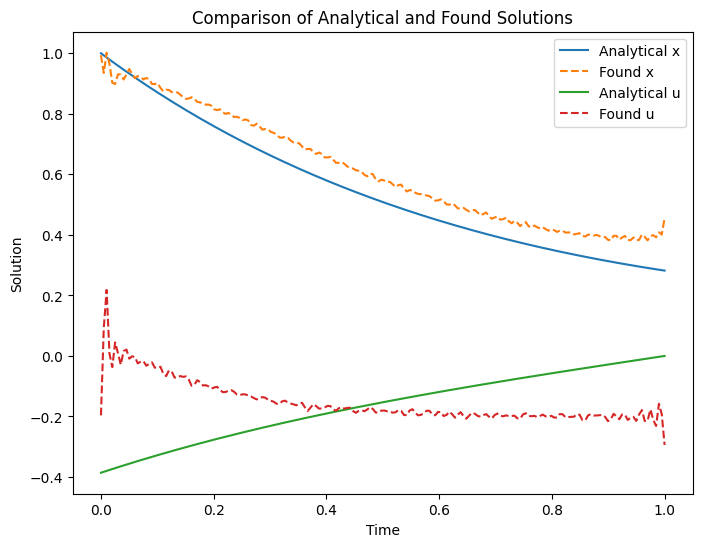

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Define analytical solutions using NumPy (if not defined yet)
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

# Create a time grid for plotting. Here t_plot is a NumPy array of shape (m,)
t_plot = np.linspace(0, end_time, m)

# Compute analytical solutions.
analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)

# Prepare inputs for the FNO model.
# u_opt is assumed to be the optimized control (1D tensor of shape (m,))
# We create a time tensor of shape (1, m) and a control tensor of shape (1, m)

x_found = x_opt.cpu().detach().numpy()# Flatten to shape (m,)
u_found = u_opt.cpu().detach().numpy()  # Already shape (m,)

# Plot the results.
plt.figure(figsize=(8, 6))
plt.plot(t_plot, analytical_x_vals, label="Analytical x")
plt.plot(t_plot, x_found.T, label="Found x", linestyle='--')
plt.plot(t_plot, analytical_u_vals, label="Analytical u")
plt.plot(t_plot, u_found.T, label="Found u", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Solution")
plt.legend()
plt.title("Comparison of Analytical and Found Solutions")
plt.show()


In [130]:
import torch
import numpy as np

# Define time grid
m = 200
t = torch.linspace(0, 1, m, device=device).unsqueeze(0).to(torch.float32).to(device)  # shape: [1, m]

# Define control function u(t)
u = -0.4 * torch.cos(np.pi * t).to(device)  # shape: [1, m]

# Analytical solution via cumulative integration
from scipy.integrate import cumulative_trapezoid as cumtrapz


t_np = t.squeeze().cpu().numpy()
u_np = u.squeeze().cpu().numpy()
exp_s = np.exp(t_np)
integrand = exp_s * u_np
integral = cumtrapz(integrand, t_np, initial=0.0)

x_analytical = np.exp(-t_np) * (1 + integral)
x_analytical = torch.tensor(x_analytical, dtype=torch.float32).unsqueeze(0)  # shape: [1, m]

# Prepare t and u for model
t_model = t.clone().detach().requires_grad_(True)
u_model = u.clone().detach()

# Predict with trained model
x_pred = trained_model(u_model, t_model)  # shape: [1, m]


In [131]:
dx = torch.autograd.grad(outputs=x_pred.sum(), inputs=t_model, create_graph=True)[0]
residual = dx + x_pred - u_model
residual_norm = torch.mean(residual**2).item()
print(f"Residual norm: {residual_norm:.2e}")


Residual norm: 6.20e-05


In [132]:
mse_x = torch.mean((x_pred - x_analytical.to(x_pred.device))**2).item()
print(f"MSE between predicted and analytical x: {mse_x:.2e}")


MSE between predicted and analytical x: 1.63e-02


In [110]:
x = model(u_opt.to(device), t)  # The model's output x as a function of time t
dx_dt = torch.autograd.grad(outputs=x.sum(), inputs=t, create_graph=True)[0]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:

dx = torch.autograd.grad(
        outputs=x_opt.sum(),
        inputs=t,
        create_graph=True,
        )[0]

dx

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.